Use `sybil2` as the conda environment. 

In [294]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pandas as pd

In [295]:
def load_data(dir_name, file_prefix, type_):
    all_paths = [path for path in os.listdir(dir_name) if path.startswith(file_prefix) and path.endswith(".json")]

    print(dir_name)

    print(f"Processing {len(all_paths)} paths...")

    if type_ == "list":
        out = []
    elif type_ == "dict":
        out = {}

    for path in all_paths:
        with open(os.path.join(dir_name, path), 'r') as f:
            path_data = json.load(f)

            if type_ == "list":
                assert isinstance(path_data, list)
                out += path_data
            elif type_ == "dict":
                assert isinstance(path_data, dict)
                out |= path_data

    return out

In [296]:
def compute_annotation_stats(data):
    total_patients_with_annotations = 0
    total_scans_with_annotations = 0

    for patient_id, patient_data in data.items():
        bboxes = patient_data.get("bboxes", {})
        t0_has_bboxes = bboxes.get("T0_has_bboxes", False)
        t1_has_bboxes = bboxes.get("T1_has_bboxes", False)
        t2_has_bboxes = bboxes.get("T2_has_bboxes", False)
        
        if t0_has_bboxes or t1_has_bboxes or t2_has_bboxes:
            total_patients_with_annotations += 1
        
        total_scans_with_annotations += int(t0_has_bboxes) + int(t1_has_bboxes) + int(t2_has_bboxes)

    return total_patients_with_annotations, total_scans_with_annotations

In [297]:
def compute_basic_statistics(data, should_prune_t0=False, should_prune_unann=False):
    num_patients = len(data)
    scan_counts = [len(patient_data['total_num_nodules']) for patient_data in data.values()]
    
    num_scans = sum(scan_counts)
    num_patients_1_scan = sum(1 for c in scan_counts if c == 1)
    num_patients_2_scan = sum(1 for c in scan_counts if c == 2)
    num_patients_3_scan = sum(1 for c in scan_counts if c == 3)
    
    total_predicted_nodules = sum(
        sum(patient_data['total_num_nodules'].values()) for patient_data in data.values()
    )
    
    unmatched_nodules = sum(len(patient_data.get("unmatched_nodules", {})) for patient_data in data.values())
    matched_nodules_count = defaultdict(int)
    
    for patient_data in data.values():
        for nodule_id, timepoints in patient_data.get("matched_nodules", {}).items():
            assert len(timepoints) in {1, 2, 3}
            matched_nodules_count[len(timepoints)] += 1
    
    matched_nodules_2 = matched_nodules_count[2]
    matched_nodules_3 = matched_nodules_count[3]
    
    if not should_prune_t0 and not should_prune_unann:
        assert total_predicted_nodules == unmatched_nodules + 2 * matched_nodules_2 + 3 * matched_nodules_3

    num_patients_with_annotations, num_scans_with_annotations = compute_annotation_stats(data)
    
    return {
        "num_patients": num_patients,
        "num_patients_1_scan": num_patients_1_scan,
        "num_patients_2_scan": num_patients_2_scan,
        "num_patients_3_scan": num_patients_3_scan,
        "num_scans": num_scans,
        "total_predicted_nodules": total_predicted_nodules,
        "unmatched_nodules": unmatched_nodules,
        "matched_nodules_2": matched_nodules_2,
        "matched_nodules_3": matched_nodules_3,
        "num_patients_with_annotations": num_patients_with_annotations,
        "num_scans_with_annotations": num_scans_with_annotations,
    }

In [298]:
def compute_distributions(data, should_prune_t0=False):
    nodules_per_scan = []
    nodules_per_patient = []
    all_volumes = []
    matched_volumes = []
    
    for patient_id, patient_data in data.items():
        nodules_per_patient.append(sum(patient_data['total_num_nodules'].values()))
        
        for timepoint, count in patient_data['total_num_nodules'].items():
            nodules_per_scan.append(count)
        
        # matched
        for nodule in patient_data.get("matched_nodules", {}).values():
            for timepoint_data in nodule.values():
                all_volumes.append(timepoint_data["mask_volume"])
                matched_volumes.append(timepoint_data["mask_volume"])
        
        # unmatched
        for nodule in patient_data.get("unmatched_nodules", {}).values():
            all_volumes.append(nodule["mask_volume"])

    if not should_prune_t0:
        assert len(all_volumes) == sum(nodules_per_scan) and len(all_volumes) == sum(nodules_per_patient)
                
    return nodules_per_scan, nodules_per_patient, all_volumes, matched_volumes

In [299]:
def plot_distribution(data, title, xlabel, ylabel, with_mean=True, xlim=None, drop_vert_line=False):
    num_bins = 30
    size = 12
    print(data)
    plt.hist(data, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5)
    plt.title(f"{title} (N = {len(data)})", size=size)

    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)
    
    if with_mean:
        text_str = f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}"
    else:
        text_str = f"Median: {median_val:.2f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.xlabel(xlabel, size=size)
    plt.ylabel(ylabel, size=size)

    if drop_vert_line:
        plt.axvline(x=0, color='black', linestyle='dotted', linewidth=1)
        
    plt.show()

In [300]:
def plot_distribution_overlay(data1, data2, title, xlabel, ylabel, label1, label2, xlim=None):
    num_bins = 30
    size = 20
    plt.hist(data1, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5, color="blue", label=label1)
    plt.hist(data2, bins=np.linspace(xlim[0], xlim[1], num_bins) if xlim is not None else num_bins, alpha=0.5, color="red", label=label2)
    plt.title(f"{title} (N of {label1} = {len(data1)}, N of {label2} = {len(data2)})", size=size)

    # text_str = f"Median ({label1}): {np.median(data1):.2f}\nMedian ({label2}): {np.median(data2):.2f}"
    text_str = f"Median ({label1}): {np.median(data1):.2f}\nMedian ({label2}): {np.median(data2):.2f}\nMean ({label1}): {np.mean(data1):.2f}\nMean ({label2}): {np.mean(data2):.2f}"
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.xlabel(xlabel, size=size)
    plt.ylabel(ylabel, size=size)
    plt.legend()
    plt.show()

In [301]:
def prune_t0(data):
    out = {}

    for pid, pid_entry in data.items():
        out[pid] = {}
        out[pid]['matched_nodules'] = {
            k: v for k, v in pid_entry['matched_nodules'].items() if v.get('timepoint') != 'T0'
        }
        out[pid]['unmatched_nodules'] = {
            k: v for k, v in pid_entry['unmatched_nodules'].items() if v.get('timepoint') != 'T0'
        }
        out[pid]['bboxes'] = {k: v for k, v in pid_entry['bboxes'].items() if 'T0' not in k}
        out[pid]['reg_metrics'] = {k: v for k, v in pid_entry['reg_metrics'].items() if 'T0' not in k}

        out[pid]['total_num_voxels'] = {k: v for k, v in pid_entry['total_num_voxels'].items() if 'T0' not in k}
        out[pid]['total_num_nodules'] = {k: v for k, v in pid_entry['total_num_nodules'].items() if 'T0' not in k}

        if "T0" in pid_entry['total_num_voxels']:
            out[pid]['num_scans'] = pid_entry["num_scans"] - 1
        else:
            out[pid]['num_scans'] = pid_entry["num_scans"]

    return out
    

In [302]:
import re
from copy import deepcopy

def filter_patients_with_bboxes(all_patients):
    """
    Given a dict of patient entries, returns a new dict containing only those patients
    that have at least one bounding box (matched or unmatched), and with all summary
    fields updated to reflect only the preserved nodules.

    all_patients: {
        patient_id: {
            'matched_nodules': { nodule_id: {T0: {...}, T1: {...}, ...}, ... },
            'unmatched_nodules': { nodule_id: {..., 'timepoint': 'T0'}, ... },
            'bboxes': { 'T0_has_bboxes': bool, 'T1_has_bboxes': bool, ... },
            'reg_metrics': {...},
            'total_num_voxels': {'T0': int, 'T1': int, ...},
            'total_num_nodules': {'T0': int, 'T1': int, ...},
            'num_scans': int
        },
        ...
    }
    """
    out = {}
    timepoints = {"T0", "T1", "T2"}

    for pid, entry in all_patients.items():
        e = deepcopy(entry)

        # 1) filter matched_nodules: keep only those with any bbox_slice_range non-empty
        new_matched = {}
        for nid, ninfo in e['matched_nodules'].items():
            # check across all timepoints for this nodule
            has_box = any(
                (slice_list := ninfo.get(tp, {}).get('bbox_slice_range', []))
                for tp in timepoints
            )
            if has_box:
                # but prune out the empty‐bbox timepoints
                pruned = {
                    tp: sub
                    for tp, sub in ninfo.items()
                    if sub.get('bbox_slice_range')
                }
                new_matched[nid] = pruned

        # 2) filter unmatched_nodules: keep only those whose bbox_slice_range is non-empty
        new_unmatched = {}
        for nid, ninfo in e['unmatched_nodules'].items():
            if ninfo.get('bbox_slice_range'):
                new_unmatched[nid] = ninfo

        # if no bbox‐bearing nodules, skip this patient
        if not (new_matched or new_unmatched):
            continue

        # 3) recompute bboxes → “T*_has_bboxes”
        new_bboxes = {}
        for tp in sorted(timepoints):
            flag = any(
                tp in ninfo and ninfo[tp].get('bbox_slice_range')
                for ninfo in new_matched.values()
            ) or any(
                ninfo['timepoint'] == tp and ninfo.get('bbox_slice_range')
                for ninfo in new_unmatched.values()
            )
            new_bboxes[f"{tp}_has_bboxes"] = flag

        # 4) recompute total_num_nodules and total_num_voxels per TP
        new_tot_nod = {tp: 0 for tp in timepoints}
        new_tot_vox = {tp: 0 for tp in timepoints}

        # matched: count & sum for each TP where it survives
        for ninfo in new_matched.values():
            for tp, sub in ninfo.items():
                new_tot_nod[tp] += 1
                new_tot_vox[tp] += sub.get('mask_volume', 0)

        # unmatched: likewise
        for ninfo in new_unmatched.values():
            tp = ninfo['timepoint']
            new_tot_nod[tp] += 1
            new_tot_vox[tp] += ninfo.get('mask_volume', 0)

        # 5) recompute reg_metrics: any metric involving T_i & T_j gets zeroed unless both have bboxes
        new_reg = {}
        for k, v in e['reg_metrics'].items():
            # extract the two T’s from the key
            tps = re.findall(r'_for_(T\d)_.*_and_(T\d)', k)
            if tps:
                t0, t1 = tps[0]
                # keep only if both timepoints still have boxes
                if new_bboxes.get(f"{t0}_has_bboxes") and new_bboxes.get(f"{t1}_has_bboxes"):
                    new_reg[k] = v
                else:
                    new_reg[k] = None
            else:
                # if it doesn't follow that naming, keep as-is
                new_reg[k] = v

        # 6) num_scans = number of timepoints that still have bboxes
        new_num_scans = sum(new_bboxes.values())

        # assemble the filtered entry
        filtered = {
            **{k: v for k, v in e.items() if k not in (
                'matched_nodules', 'unmatched_nodules', 'bboxes',
                'reg_metrics', 'total_num_voxels', 'total_num_nodules', 'num_scans'
            )},
            'matched_nodules': new_matched,
            'unmatched_nodules': new_unmatched,
            'bboxes': new_bboxes,
            'reg_metrics': new_reg,
            'total_num_voxels': new_tot_vox,
            'total_num_nodules': new_tot_nod,
            'num_scans': new_num_scans
        }

        out[pid] = filtered

    return out


In [303]:
def filter_cancer_window_nodules_only(data, metadata):
    pid_subset = set()

    DAY_THRESH = 2 * 365 # two years

    for i, row in metadata.iterrows():
        if any([row[f"Days2Cancer_{tp}"] <= DAY_THRESH for tp in range(2)]):
            pid_subset.add(str(row["PID"]))

    return {pid: pid_entry for pid, pid_entry in data.items() if pid in pid_subset}

In [ ]:
# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_1"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_1_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_2"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_2_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/nnInteractive_all_mask_min_3"
# file_prefix = "matching_outputs_nnInteractive_all_mask_min_3_mcs_25_new_group"

# dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/tsm_25dfb675_nn_all_mask_min_1_no_mask"
# file_prefix = "matching_outputs_tsm_25dfb675_nn_all_mask_min_1_no_mask_mcs_25_new_group"

is_cancer = False
include_within_cancer_window_nodules_only = False
include_ann_nodules_only = False

assert (not include_ann_nodules_only and not include_within_cancer_window_nodules_only) or include_ann_nodules_only != include_within_cancer_window_nodules_only

if is_cancer:
    # BMP-based (old)

    # dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen"
    # file_prefix = "matching_outputs_frozen_mcs_25_new_group"

    # nnU-Net-based
    # dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen_nnunet_b3_after_lung_mask"
    # file_prefix = "matching_outputs_frozen_nnunet_b3_after_lung_mask_mcs_25_new_group"

    # dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen4"
    # file_prefix = "matching_outputs_frozen4_mcs_25_new_group"

    dir_name = "/data/rbg/scratch/nlst_nodules/v2/matching/frozen5"
    file_prefix = "matching_outputs_frozen5_mcs_25_new_group"

    metadata = pd.read_csv("/data/rbg/users/pgmikhael/current/SybilX/notebooks/NoduleGrowth/nlst_cancer_nodules.csv")
else:
    assert not include_ann_nodules_only and not include_within_cancer_window_nodules_only

    dir_name = "/data/rbg/scratch/nlst_benign_nodules/v2/matching/frozen5"
    file_prefix = "matching_outputs_frozen5_mcs_25_new_group"
    metadata = pd.read_csv("/data/rbg/users/pgmikhael/current/SybilX/notebooks/NoduleGrowth/nlst_benign_nodules.csv")

data = load_data(dir_name, file_prefix, "dict")

data = {k:v for k,v in data.items() if not (k == "116970" and not is_cancer)} # corrupted output

should_prune_t0 = False

if should_prune_t0:
    data = prune_t0(data)

if include_ann_nodules_only:
    data = filter_patients_with_bboxes(data)

elif include_within_cancer_window_nodules_only:
    data = filter_cancer_window_nodules_only(data, metadata)

skipped = load_data(dir_name, file_prefix.replace("outputs", "skipped"), "list")

stats = compute_basic_statistics(data, should_prune_t0, include_ann_nodules_only)


/data/rbg/scratch/nlst_nodules/v2/matching/frozen5
Processing 14 paths...
/data/rbg/scratch/nlst_nodules/v2/matching/frozen5
Processing 14 paths...


In [305]:
# number of skipped is an undercount for BMP2D_FINETUNED
print("Basic Statistics:\n\n")
print(f"num_skipped_patients: {len(skipped)}")
for key, value in stats.items():
    print(f"{key}: {value}")

Basic Statistics:


num_skipped_patients: 95
num_patients: 693
num_patients_1_scan: 258
num_patients_2_scan: 167
num_patients_3_scan: 268
num_scans: 1396
total_predicted_nodules: 14424
unmatched_nodules: 9858
matched_nodules_2: 1488
matched_nodules_3: 530
num_patients_with_annotations: 475
num_scans_with_annotations: 774


[9, 8, 8, 6, 21, 4, 8, 6, 7, 13, 1, 7, 5, 15, 9, 12, 9, 10, 5, 6, 6, 9, 11, 10, 11, 18, 11, 7, 11, 7, 8, 11, 19, 7, 5, 3, 1, 9, 8, 8, 12, 15, 10, 5, 9, 12, 10, 10, 5, 3, 1, 3, 6, 5, 8, 6, 2, 2, 8, 2, 18, 10, 10, 9, 8, 14, 12, 16, 20, 21, 5, 11, 12, 5, 4, 3, 10, 12, 8, 16, 9, 8, 3, 10, 8, 6, 8, 8, 10, 9, 7, 12, 9, 8, 23, 6, 9, 8, 7, 11, 9, 9, 3, 10, 3, 4, 2, 6, 2, 2, 11, 12, 8, 15, 12, 7, 7, 3, 10, 10, 5, 5, 6, 9, 8, 5, 16, 11, 4, 4, 5, 14, 14, 8, 7, 14, 18, 15, 14, 9, 14, 3, 3, 4, 2, 4, 1, 4, 7, 14, 8, 11, 12, 8, 10, 10, 10, 5, 11, 10, 12, 8, 13, 2, 11, 9, 13, 12, 20, 19, 16, 9, 5, 6, 8, 4, 10, 9, 2, 6, 7, 6, 6, 9, 7, 9, 16, 5, 8, 7, 15, 16, 16, 6, 10, 11, 2, 5, 6, 9, 5, 10, 8, 10, 8, 11, 17, 11, 12, 10, 16, 11, 9, 8, 15, 15, 14, 13, 10, 17, 12, 9, 10, 12, 8, 11, 10, 6, 15, 11, 9, 10, 14, 15, 10, 12, 20, 14, 21, 11, 14, 30, 23, 6, 15, 8, 15, 7, 3, 4, 32, 21, 9, 13, 7, 5, 5, 4, 9, 15, 11, 15, 12, 24, 4, 9, 8, 18, 24, 19, 18, 4, 10, 8, 11, 13, 16, 14, 26, 7, 8, 9, 11, 13, 10, 12, 13, 14,

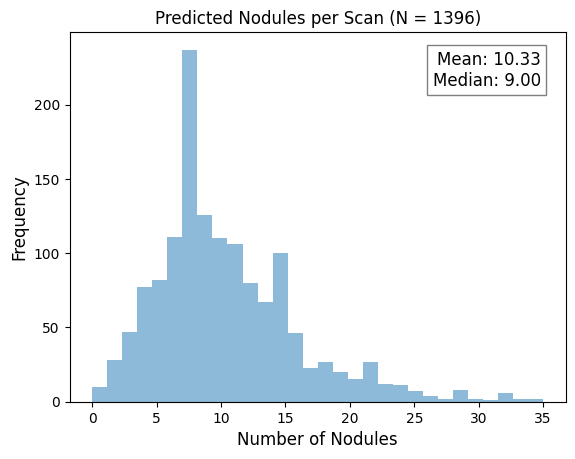

[9, 22, 21, 12, 26, 13, 24, 31, 17, 9, 11, 39, 29, 26, 19, 12, 4, 25, 37, 5, 21, 25, 7, 11, 8, 8, 12, 18, 20, 31, 12, 57, 28, 12, 10, 20, 33, 21, 22, 19, 28, 8, 23, 23, 27, 9, 16, 6, 10, 23, 35, 14, 3, 20, 5, 20, 13, 16, 11, 8, 5, 28, 8, 7, 47, 37, 6, 6, 9, 7, 33, 12, 8, 10, 10, 26, 10, 33, 2, 20, 25, 55, 9, 11, 8, 4, 21, 6, 7, 21, 32, 5, 8, 7, 15, 32, 27, 13, 24, 18, 8, 28, 11, 22, 27, 9, 8, 30, 37, 29, 19, 12, 19, 10, 32, 19, 29, 22, 20, 46, 14, 30, 29, 38, 14, 32, 30, 13, 7, 5, 9, 9, 41, 12, 24, 21, 42, 41, 29, 43, 26, 24, 34, 12, 39, 29, 79, 10, 9, 16, 48, 9, 16, 24, 25, 9, 20, 11, 70, 36, 31, 13, 10, 7, 53, 8, 25, 46, 13, 10, 38, 6, 38, 43, 43, 20, 63, 14, 42, 8, 37, 19, 14, 74, 11, 57, 8, 6, 36, 11, 12, 2, 17, 40, 14, 11, 34, 7, 7, 17, 23, 7, 12, 24, 16, 4, 4, 8, 12, 12, 22, 45, 6, 19, 23, 9, 16, 8, 30, 2, 23, 24, 10, 17, 28, 13, 10, 51, 18, 6, 39, 6, 5, 18, 13, 22, 20, 10, 19, 8, 26, 16, 54, 11, 18, 21, 9, 6, 26, 22, 14, 17, 8, 3, 10, 6, 11, 24, 3, 7, 23, 21, 21, 8, 6, 23, 1, 29

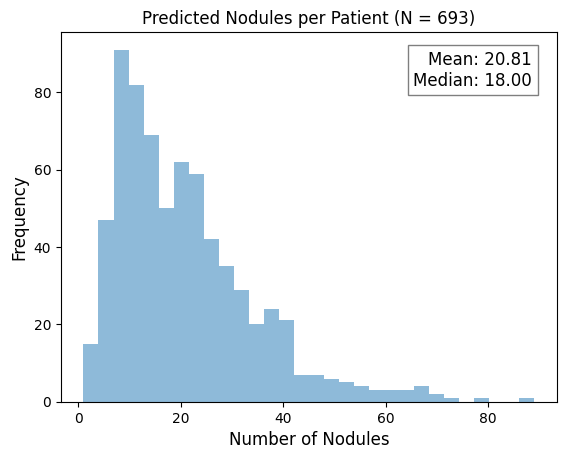

[73.861083984375, 647.841796875, 39.1552734375, 1199.5751953125, 597.117919921875, 99.66796875, 661.190185546875, 40.045166015625, 187.767333984375, 307.50732421875, 211.5966796875, 121.61865234375, 639.73388671875, 920.54443359375, 46.47216796875, 81.0791015625, 228.40576171875, 571.5087890625, 39.55078125, 44.49462890625, 53.3935546875, 407.373046875, 34.60693359375, 42.51708984375, 247.1923828125, 79.32139205932617, 61.69441604614258, 424.1491103172302, 219.23551416397095, 42.96575403213501, 336.01423025131226, 86.671875, 8080.3466796875, 51.46142578125, 90.283203125, 170.63525390625, 139.93896484375, 48.7529296875, 213.97119140625, 53.26708984375, 117.3681640625, 142.6474609375, 130.91064453125, 31.59912109375, 41.5302734375, 59.5869140625, 27.98779296875, 257.30712890625, 420.7197265625, 50.55859375, 172.44091796875, 81.2548828125, 93.1832999587059, 3422.3785400390625, 105.84899121522903, 767.5323486328125, 1291.9005081653595, 220.74490475654602, 795.95947265625, 3768.447875976562

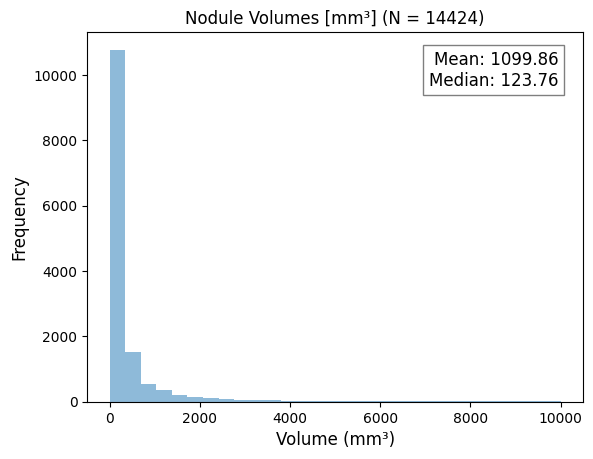

[307.50732421875, 211.5966796875, 93.1832999587059, 3422.3785400390625, 105.84899121522903, 767.5323486328125, 86.1418604850769, 119.52445721626282, 597.2502326965332, 74.26762390136719, 95.33032560348511, 75.42805552482605, 107.96446514129639, 89.3532350063324, 436.3222904205322, 93.99496150016785, 67.30503416061401, 71.51055908203125, 88.89999389648438, 40.24181365966797, 44.034576416015625, 29.967308044433594, 37.387847900390625, 43.666648864746094, 706.6074163913727, 1270.5078125, 261.1972939968109, 392.578125, 40.325196266174316, 246.09375, 208.95783519744873, 113.28125, 253.86544013023376, 204.1015625, 52.23945879936218, 95.703125, 99.23134887218475, 104.277010679245, 333.01367926597595, 318.71763747930527, 102.80616343021393, 80.73058891296387, 60.5479416847229, 102.59512341022491, 200.98552864789963, 28.59208357334137, 69.79832166433334, 85.77625072002411, 126.98248881101608, 229.16830426454544, 239.6755439043045, 136.70329904556274, 129.7760009765625, 133.39596116542816, 127.4

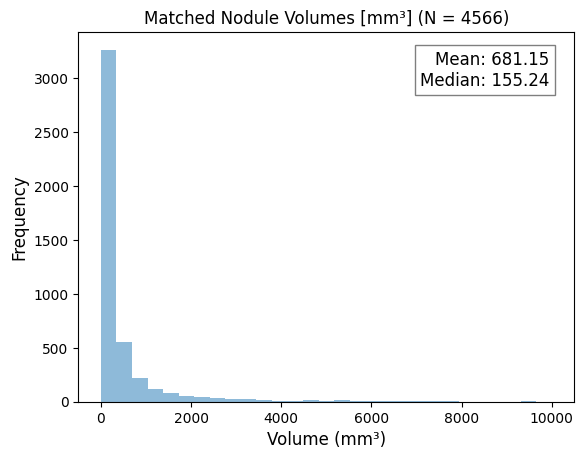

In [306]:
nodules_per_scan, nodules_per_patient, all_volumes, matched_volumes = compute_distributions(data, should_prune_t0)

# plot_distribution(nodules_per_scan, "Predicted Nodules per Scan\n", "Number of Nodules", "Frequency")
plot_distribution(nodules_per_scan, "Predicted Nodules per Scan", "Number of Nodules", "Frequency")
plot_distribution(nodules_per_patient, "Predicted Nodules per Patient", "Number of Nodules", "Frequency")
plot_distribution(all_volumes, "Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 10000))
# plot_distribution(all_volumes, "Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 2500))
# plot_distribution(all_volumes, "Nodule Volumes (mm³)", "Volume (mm³)", "Frequency")
plot_distribution(matched_volumes, "Matched Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 10000))
# plot_distribution(matched_volumes, "Matched Nodule Volumes [mm³]", "Volume (mm³)", "Frequency", xlim=(0, 2500))

## Registration

In [307]:
all_bbox_mask_iou_vals = []

all_predicted_ious_pairwise = []
all_predicted_min_dist_pairwise = []
all_predicted_centroid_dist_pairwise = []

for pid_entry in data.values():
    for v in pid_entry["reg_metrics"].values():
        if v is not None:
            all_bbox_mask_iou_vals.append(v)
    
    # TODO: broken!
    
    # for nodule_idx in pid_entry["matched_nodules"]:
    #     for tp in pid_entry["matched_nodules"][nodule_idx]:
    #         curr_entry = pid_entry["matched_nodules"][nodule_idx][tp]

    #         if tp == "T0":
    #             # print(curr_entry)
    #             all_predicted_ious_pairwise.append(curr_entry["iou_with_T1_nodule_after_reg"])
    #             all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T1_nodule"])
    #             all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T1_nodule"])
    #         elif tp == "T1":
    #             if "iou_with_T0_nodule_after_reg" in curr_entry and "min_distance_to_T0_nodule" in curr_entry and "centroid_distance_to_T0_nodule" in curr_entry:
    #                 all_predicted_ious_pairwise.append(curr_entry["iou_with_T0_nodule_after_reg"])
    #                 all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T0_nodule"])
    #                 all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T0_nodule"])

    #             if "iou_with_T2_nodule_after_reg" in curr_entry and "min_distance_to_T2_nodule" in curr_entry and "centroid_distance_to_T2_nodule" in curr_entry:
    #                 all_predicted_ious_pairwise.append(curr_entry["iou_with_T2_nodule_after_reg"])
    #                 all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T2_nodule"])
    #                 all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T2_nodule"])
    #         elif tp == "T2":
    #             print(curr_entry)
    #             all_predicted_ious_pairwise.append(curr_entry["iou_with_registered_T1_nodule"])
    #             all_predicted_min_dist_pairwise.append(curr_entry["min_distance_to_T1_nodule"])
    #             all_predicted_centroid_dist_pairwise.append(curr_entry["centroid_distance_to_T1_nodule"])


[0.19533382973442542, 0.16557960272754224, 0.0, 0.4587616250611845, 0.4321617447465718, 0.3346968950221784, 0.04943934760448522, 0.14936240230357878, 0.5790070045323444, 0.17419497457814456, 0.0, 0.0, 0.0, 0.31812798213258436, 0.12216110233647405, 9.423738397022099e-05, 0.35271408516612074, 0.43328856055518244, 0.4252615844544096, 0.23613622664255576, 0.1904535900739033, 0.21220394945710838, 0.018207904895296008, 0.45218504296946427, 0.3131810424051464, 0.6682352144622363, 0.7036928773263178, 0.23183490457576456, 0.0, 0.11540153251383198, 0.4505951044239838, 0.0, 0.2137368534020176, 0.13197994255391657, 0.3949455273104573, 0.0, 0.2547391725473917, 0.7495620848068215, 0.40930775971180994, 0.037815126050420166, 0.3465089134125637, 0.5607772964148929, 0.2089767469807126, 0.13952986844942852, 0.6790604957531634, 0.0, 0.1277330809275911, 0.5210743751590119, 0.4612972585558144, 0.41471363303238684, 0.6069464544138929, 0.20961887477313976, 0.07115520380485267, 0.04614322805403096, 0.0, 0.0, 0

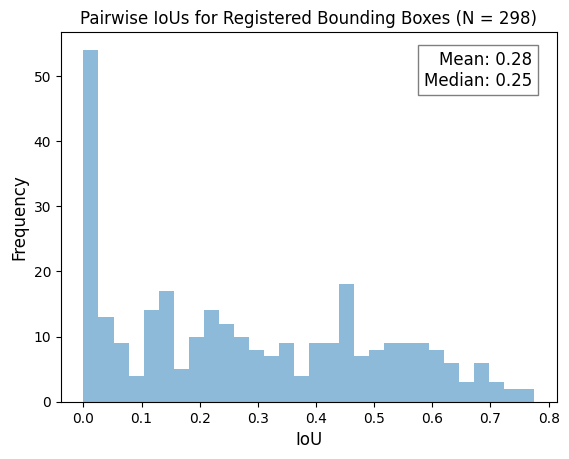

In [308]:
plot_distribution(all_bbox_mask_iou_vals, "Pairwise IoUs for Registered Bounding Boxes", "IoU", "Frequency")

# plot_distribution(all_bbox_mask_iou_vals, "Pairwise IoUs for Predicted Matched Longitudinal Nodules", "IoU", "Frequency")
# plot_distribution(all_bbox_mask_iou_vals, "Pairwise Minimum Distance for Predicted Matched Longitudinal Nodules", "Minimum Distance", "Frequency")
# plot_distribution(all_bbox_mask_iou_vals, "Pairwise Centroid Distance for Predicted Matched Longitudinal Nodules", "Centroid Distance", "Frequency")

## Growth

In [309]:
metadata.columns

Index(['PID', 'IsSmallCell', 'CancerTP', 'NumExams', 'Days2Cancer_0',
       'DaysSinceRand_0', 'Annotated_0', 'Days2FUP_0', 'Series_0',
       'abnormalities_0', 'attentuations_0', 'longest_diameter_0',
       'perp_diameter_0', 'growth_0', 'change_0', 'exists_0', 'slice_number_0',
       'age_0', 'years_since_quit_smoking_0', 'Days2Cancer_1',
       'DaysSinceRand_1', 'Annotated_1', 'Days2FUP_1', 'Series_1',
       'abnormalities_1', 'attentuations_1', 'longest_diameter_1',
       'perp_diameter_1', 'growth_1', 'change_1', 'exists_1', 'slice_number_1',
       'age_1', 'years_since_quit_smoking_1', 'Days2Cancer_2',
       'DaysSinceRand_2', 'Annotated_2', 'Days2FUP_2', 'Series_2',
       'abnormalities_2', 'attentuations_2', 'longest_diameter_2',
       'perp_diameter_2', 'growth_2', 'change_2', 'exists_2', 'slice_number_2',
       'age_2', 'years_since_quit_smoking_2', 'age_start_smoking',
       'age_quit_smoking', 'years_smoking', 'is_smoker', 'family_hx'],
      dtype='object')

In [310]:
def volume_percentage_change(v0, v1):
    return ((v1 - v0) / v0) * 100 if v0 > 0 else np.nan

def volume_doubling_time(v0, v1, time_diff):
    if v0 > 0 and v1 > v0 and time_diff > 0:
        return (np.log(2) / np.log(v1 / v0)) * time_diff
    return np.nan

In [311]:
metadata[["DaysSinceRand_1", "DaysSinceRand_0"]]

,DaysSinceRand_1,DaysSinceRand_0
0,NaN,57.0
1,345.0,23.0
2,349.0,NaN
3,515.0,0.0
4,NaN,22.0
...,...,...
820,NaN,39.0
821,392.0,0.0
822,NaN,23.0
823,381.0,0.0


In [312]:
def compute_growth_statistics(data, df):
    growth_data = []
    unmatched_earlier = {"NSCLC": 0, "SCLC": 0, "benign": 0}
    unmatched_later = {"NSCLC": 0, "SCLC": 0, "benign": 0}
    early_detection = {"NSCLC": 0, "SCLC": 0, "benign": 0}

    for pid in data:
        patient_data = data[pid]
        if is_cancer:
            cancer_type = "NSCLC" if df.loc[df["PID"] == int(pid), "IsSmallCell"].values[0] == 0 else "SCLC"
        else:
            cancer_type = "benign"

        matched_nodules = patient_data["matched_nodules"]
        for nodule_entry in matched_nodules.values():
            # skip T0 and T2 pairs (we want one-timepoint changes)
            if "T0" in nodule_entry and "T1" in nodule_entry:
                T0, T1 = nodule_entry["T0"], nodule_entry["T1"]
                v0, v1 = T0["mask_volume"], T1["mask_volume"]

                time_diff = df.loc[df["PID"] == int(pid), "DaysSinceRand_1"].values[0] - df.loc[df["PID"] == int(pid), "DaysSinceRand_0"].values[0]
                    
                growth_data.append({
                    "PID": pid,
                    "volume_change": volume_percentage_change(v0, v1),
                    "doubling_time": volume_doubling_time(v0, v1, time_diff),
                    "cancer_type": cancer_type,
                    "first": "T0",
                    "second": "T1",
                })

            if "T1" in nodule_entry and "T2" in nodule_entry:
                T1, T2 = nodule_entry["T1"], nodule_entry["T2"]
                v1, v2 = T1["mask_volume"], T2["mask_volume"]

                time_diff = df.loc[df["PID"] == int(pid), "DaysSinceRand_2"].values[0] - df.loc[df["PID"] == int(pid), "DaysSinceRand_1"].values[0]
                    
                growth_data.append({
                    "PID": pid,
                    "volume_change": volume_percentage_change(v1, v2),
                    "doubling_time": volume_doubling_time(v1, v2, time_diff),
                    "cancer_type": cancer_type,
                    "first": "T1",
                    "second": "T2",
                })
        
        # Unmatched nodules appearing earlier or later
        unmatched_nodules = patient_data["unmatched_nodules"]
        for nodule in unmatched_nodules.values():
            timepoint = nodule["timepoint"]
            if timepoint == "T2":
                if patient_data["total_num_nodules"].get("T0", 0) > 0 or patient_data["total_num_nodules"].get("T1", 0) > 0:
                    unmatched_earlier[cancer_type] += 1
            elif timepoint == "T1":
                if patient_data["total_num_nodules"].get("T0", 0) > 0:
                    unmatched_earlier[cancer_type] += 1
                if patient_data["total_num_nodules"].get("T2", 0) > 0:
                    unmatched_later[cancer_type] += 1
            elif timepoint == "T0":
                if patient_data["total_num_nodules"].get("T1", 0) > 0 or patient_data["total_num_nodules"].get("T2", 0) > 0:
                    unmatched_later[cancer_type] += 1
        
        
        
        # # Matched nodules with an earlier scan
        # previous_scans = df.loc[df["PID"] == int(pid), "Series_0"].values
        # if len(previous_scans) > 1:
        #     matched_earlier_scan["total"] += 1
        #     if np.isnan(df.loc[df["PID"] == int(pid), "longest_diameter_0"].values[0]):
        #         matched_earlier_scan["no_diameter"] += 1

    growth_df = pd.DataFrame(growth_data)

    # # Output results
    # print("Growth Analysis:")
    # # print(growth_df.groupby("cancer_type")["volume_change", "doubling_time"].describe())

    # print("\nUnmatched nodules appearing earlier:", unmatched_earlier)
    # print("Unmatched nodules appearing later:", unmatched_later)
    # # print("\nMatched nodules with an earlier scan:", matched_earlier_scan)

    return growth_df, unmatched_earlier, unmatched_later, early_detection


In [313]:
growth_df, unmatched_earlier, unmatched_later, early_detection = compute_growth_statistics(data, metadata)

In [314]:
growth_df[growth_df["PID"] == "126967"]

,PID,volume_change,doubling_time,cancer_type,first,second
747,126967,-40.840493,NaN,NSCLC,T0,T1
748,126967,-20.296027,NaN,NSCLC,T1,T2
749,126967,-61.311991,NaN,NSCLC,T0,T1
750,126967,-36.090498,NaN,NSCLC,T0,T1
751,126967,59.556787,550.387963,NSCLC,T1,T2
752,126967,-52.592734,NaN,NSCLC,T0,T1
753,126967,257.062215,202.050406,NSCLC,T1,T2
754,126967,146.779569,221.757911,NSCLC,T0,T1
755,126967,424.933604,155.091584,NSCLC,T1,T2
756,126967,22.747271,1254.688401,NSCLC,T1,T2


In [315]:
cols = [col for col in metadata.columns if "_0" in col]

In [316]:
annotations = json.load(open("/data/rbg/shared/datasets/NLST/NLST/annotations_122020.json", "r"))

In [317]:
annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"]

{'1.2.840.113654.2.55.163157187122431509690781522115404072036': [{'x': 0.57159541015625,
   'y': 0.58550396484375,
   'width': 0.0838051953125,
   'height': 0.07701021484375,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.253307140210856805054979155186064149226': [{'x': 0.56593287109375,
   'y': 0.58323896484375,
   'width': 0.09060025390625,
   'height': 0.0792751953125,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.58364372794881369367486462306831359202': [{'x': 0.5703125,
   'y': 0.583984375,
   'width': 0.0859375,
   'height': 0.078125,
   'user': 'pbourgouin@bwh.harvard.edu'}],
 '1.2.840.113654.2.55.106110028426812472195508696323718613319': [{'x': 0.568359375,
   'y': 0.583984375,
   'width': 0.087890625,
   'height': 0.078125,
   'user': 'pbourgouin@bwh.harvard.edu'}]}

In [318]:
import torch
import math
import numpy as np
slice_ids = list(annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"].keys())
mask = torch.zeros((197, 512, 512))
W, H = mask.shape[1:]
for i, slice in enumerate(slice_ids):
    for bbox in annotations["1.2.840.113654.2.55.46740908853597772128064307566173363217"].get(slice, []):
        x_left, y_top = bbox["x"] * W, bbox["y"] * H
        x_right, y_bottom = x_left + bbox["width"] * W, y_top + bbox["height"] * H
        x_left, y_top = math.floor(x_left), math.floor(y_top)
        x_right, y_bottom = math.ceil(x_right), math.ceil(y_bottom)
        mask[i,y_top:y_bottom, x_left:x_right] = 1
        print(x_left)

292
289
292
291


In [319]:
np.count_nonzero(mask)

7380

In [320]:
growth_df[growth_df["volume_change"] < 0].describe()

,volume_change,doubling_time
count,1132.000000,0.0
mean,-37.353899,NaN
std,25.137143,NaN
min,-99.678622,NaN
25%,-55.316977,NaN
50%,-33.803481,NaN
75%,-16.511862,NaN
max,-0.064284,NaN


In [321]:
# days_to_cancer_from_earliest_matched_scan = get_days_to_cancer_from_earliest_matched_scan(data, metadata)
# days_to_cancer_from_last_scan = get_days_to_cancer_from_last_scan(data, metadata)

In [322]:
# plot_distribution(days_to_cancer_from_earliest_matched_scan, "Days to Cancer from Earliest Matched Scan", "Days", "Frequency")
# plot_distribution(days_to_cancer_from_last_scan, "Days to Cancer from Last Scan", "Days", "Frequency")

[-31.189710610932476, 3572.7380781273964, 625.120135601617, 38.75304821976659, -87.56507409531591, -20.877165742032737, -17.238292349808713, 388.3116883116883, -28.39506172839506, 24.317296686920518, -54.733614822824684, -31.945960462255492, 16.793694520967247, 79.80391700223771, 50.29946099089112, 510.27291318214606, -45.78750785154425, -19.602462471734924, 83.20083553616081, 5.084745762711865, -4.292929292929292, -67.74381102869174, -25.0, 95.90163934426229, 144.11764705882354, 48.03921568627451, 4.584944533878386, -42.963183970015564, 2.7893910751028805, -4.438629287693984, -47.799245657530165, 77.29561573935638, 39.60693424793334, 57.079777143534194, -60.142687585235436, 224.0168686274736, 436.7356920960816, 22.727885557517588, -53.608859501867144, 75.7256236748686, 492.67289504036904, -48.10452215261503, -50.81323742802177, -62.02780254913321, 82.67924622239924, -16.28309573411563, 99.17281635028942, 248.60643067668175, -2.001945114401951, -20.30878998626103, 56.46102460242012, 13

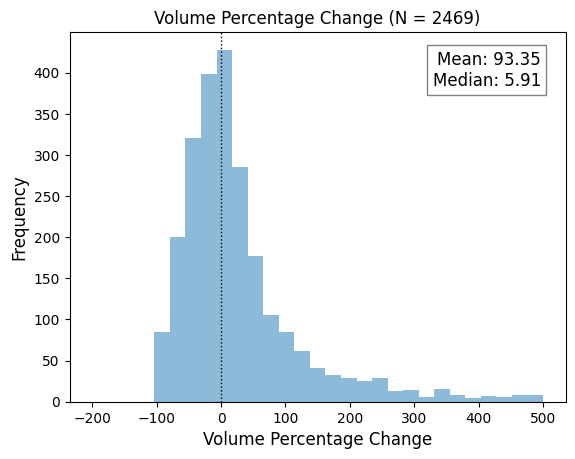

[-31.189710610932476, 38.75304821976659, -87.56507409531591, -20.877165742032737, -17.238292349808713, 388.3116883116883, -28.39506172839506, 24.317296686920518, -54.733614822824684, -31.945960462255492, 16.793694520967247, 79.80391700223771, 50.29946099089112, 510.27291318214606, -45.78750785154425, -19.602462471734924, 83.20083553616081, 5.084745762711865, -4.292929292929292, -67.74381102869174, -25.0, 95.90163934426229, 144.11764705882354, 48.03921568627451, 4.584944533878386, -42.963183970015564, 2.7893910751028805, -4.438629287693984, -47.799245657530165, 77.29561573935638, 39.60693424793334, 57.079777143534194, -60.142687585235436, 224.0168686274736, 436.7356920960816, 22.727885557517588, -53.608859501867144, 75.7256236748686, 492.67289504036904, -48.10452215261503, -50.81323742802177, -62.02780254913321, 82.67924622239924, -16.28309573411563, 99.17281635028942, 248.60643067668175, -2.001945114401951, -20.30878998626103, 56.46102460242012, 136.64307399277712, 57.28570476220114, 1

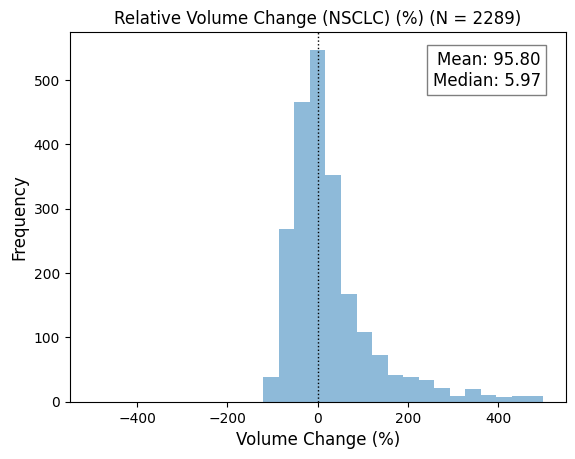

[3572.7380781273964, 625.120135601617, -44.45643475584461, -19.320778373460826, 17.02308402585411, 31.049823549501003, 67.9117118703157, 38.57996792535355, -25.38750673058833, -13.86810275115707, 11.21519027293255, 95.28227146814405, 6.574594380688563, 234.05694593180436, 206.47827469276746, 38.47870082408437, 17.5, 11.267605633802818, 118.50030263157896, -5.252640790684382, 7.883642304977228, -20.151863623066383, -44.75153629201823, 164.07766990291262, -14.85148514851485, 417.94341726678914, 38.61462130972287, 58.789260470819194, -41.05424741646336, -3.1239370583615296, 31.57894736842105, -40.719626191336424, -0.6855599987171741, -16.80805332158652, -29.8510626844074, -51.745136679495516, -36.86497496091047, 482.4523490983184, -41.57088115990823, 148.84681084508378, -70.31339944334657, 17.6120848063765, -5.420584862981915, -6.254227139712764, -79.64046790393479, 89.47986041852842, 9.760913428320563, -33.806339661282095, 57.81639667461806, -3.7142857142857144, -34.759963768115945, -7.8

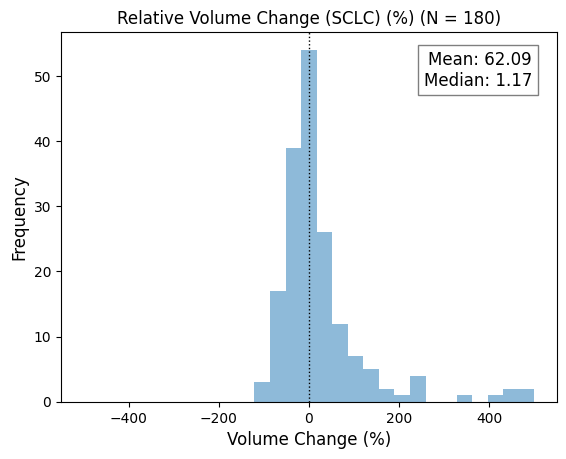

[]


/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/rbg/users/erubel/miniconda3/envs/biomedparse/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  

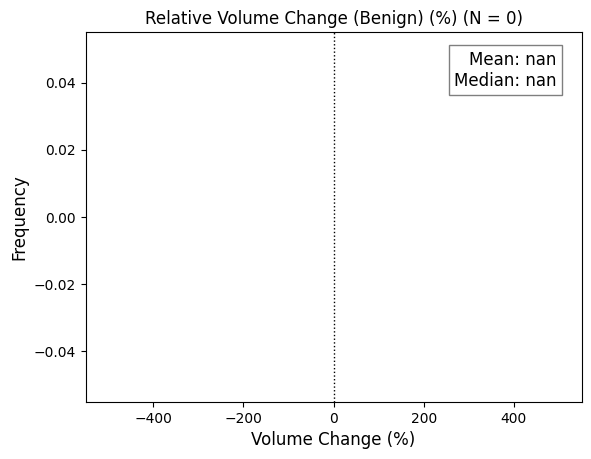

In [323]:
# plot_distribution(growth_df["volume_change"].dropna().tolist(), "Volume Change (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)
plot_distribution(growth_df["volume_change"].dropna().tolist(), "Volume Percentage Change", "Volume Percentage Change", "Frequency", xlim=(-200, 500), drop_vert_line=True)
plot_distribution(growth_df[growth_df["cancer_type"] == "NSCLC"]["volume_change"].dropna().tolist(), "Relative Volume Change (NSCLC) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)
plot_distribution(growth_df[growth_df["cancer_type"] == "SCLC"]["volume_change"].dropna().tolist(), "Relative Volume Change (SCLC) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)
plot_distribution(growth_df[growth_df["cancer_type"] == "benign"]["volume_change"].dropna().tolist(), "Relative Volume Change (Benign) (%)", "Volume Change (%)", "Frequency", xlim=(-500, 500), drop_vert_line=True)

In [324]:
metadata["Days2Cancer_0"]

0        20.0
1      1744.0
2         NaN
3       924.0
4        33.0
        ...  
820      63.0
821     459.0
822    1510.0
823     836.0
824     445.0
Name: Days2Cancer_0, Length: 825, dtype: float64

In [325]:
# of the pairs

increase_threshold = 25
decrease_threshold = -25

# increase_threshold = 20
# decrease_threshold = -10

volume_change_vals = growth_df["volume_change"].dropna().tolist()

print(f"{len([val for val in volume_change_vals if val >= increase_threshold]) / len(volume_change_vals)}% of pairs increase in volume")
print(f"{len([val for val in volume_change_vals if val <= decrease_threshold]) / len(volume_change_vals)}% of pairs decrease in volume")
print(f"{len([val for val in volume_change_vals if val < increase_threshold and val > decrease_threshold]) / len(volume_change_vals)}% of pairs maintain the same volume")

0.37221547185095183% of pairs increase in volume
0.284325637910085% of pairs decrease in volume
0.34345889023896314% of pairs maintain the same volume


In [326]:
ranges = [(-100, -25), (-25, 25), (25, 50), (50, 100), (100, 200), (200, float("inf"))]

volume_change_val = np.array(growth_df["volume_change"].dropna().tolist())

sum_ = 0
for (start_, stop_) in ranges:
    res = np.mean(np.logical_and(volume_change_val >= start_, volume_change_val < stop_))
    print(start_, stop_, res)

    sum_ += res

-100 -25 0.28351559335763465
-25 25 0.3442689347914135
25 50 0.09963547995139732
50 100 0.1012555690562981
100 200 0.07897934386391252
200 inf 0.09234507897934387


In [327]:
sum_

0.9999999999999999

In [328]:
growth_df["volume_change"].min()

-99.67862191828861

In [329]:
# plot_binned_dist(growth_df["volume_change"].dropna().tolist(), "Percent Volume Change\n", "Relative Volume Change (%)", "Frequency", xlim=(-200, 500))

In [330]:
growth_df["doubling_time"]

0              NaN
1        65.976966
2       120.004757
3       876.154381
4              NaN
           ...    
2464           NaN
2465           NaN
2466           NaN
2467    676.724810
2468           NaN
Name: doubling_time, Length: 2469, dtype: float64

[65.97696554314325, 120.00475669200745, 876.1543806688371, 148.17713854584798, 1187.795812359152, 1558.2973702200954, 362.7021879683318, 522.2510988562144, 117.64910756555503, 351.4893886149955, 5254.826888580944, 387.57713425409713, 292.02146333818865, 664.3351361517884, 5829.129127776868, 8994.39825553939, 433.3317520243411, 741.6323280702118, 549.5032966569845, 211.07632780391214, 147.26435859806, 1211.6572767867092, 447.5458028357771, 114.52004836346126, 338.19819475250006, 295.7684713001804, 202.04272041690677, 520.2822450115466, 321.8764888740035, 612.1940911175124, 1607.5076502088114, 1446.092673506929, 254.84048090240765, 407.2645350192554, 365.4847061451405, 774.6690415058654, 261.8852499097171, 1854.465658102145, 145.4293369694403, 2615.066531099079, 2259.8204898669, 64.83522211360167, 266.5564716135826, 2340.4386488622035, 479.6370435084489, 360.4227410191913, 1516.800698199891, 881.7903373010498, 501.5361302657608, 730.7973529625359, 2445.3249576952703, 356.2695745213929, 3

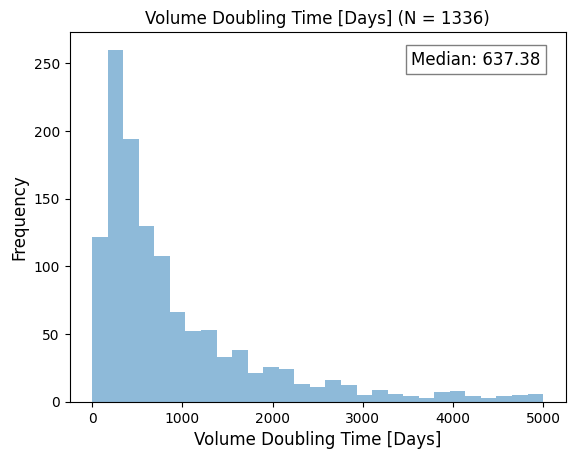

[876.1543806688371, 148.17713854584798, 1187.795812359152, 1558.2973702200954, 362.7021879683318, 522.2510988562144, 117.64910756555503, 351.4893886149955, 5254.826888580944, 387.57713425409713, 292.02146333818865, 664.3351361517884, 5829.129127776868, 8994.39825553939, 433.3317520243411, 741.6323280702118, 549.5032966569845, 211.07632780391214, 147.26435859806, 1211.6572767867092, 447.5458028357771, 114.52004836346126, 338.19819475250006, 295.7684713001804, 202.04272041690677, 520.2822450115466, 321.8764888740035, 612.1940911175124, 1607.5076502088114, 1446.092673506929, 254.84048090240765, 407.2645350192554, 365.4847061451405, 774.6690415058654, 261.8852499097171, 1854.465658102145, 145.4293369694403, 2615.066531099079, 2259.8204898669, 64.83522211360167, 266.5564716135826, 2340.4386488622035, 479.6370435084489, 360.4227410191913, 1202.8400291969456, 1380.6139678229429, 882.7758828677543, 6620.328250486654, 296.83252223117364, 540.4532894657727, 2562.5620665707033, 836.3043025227308,

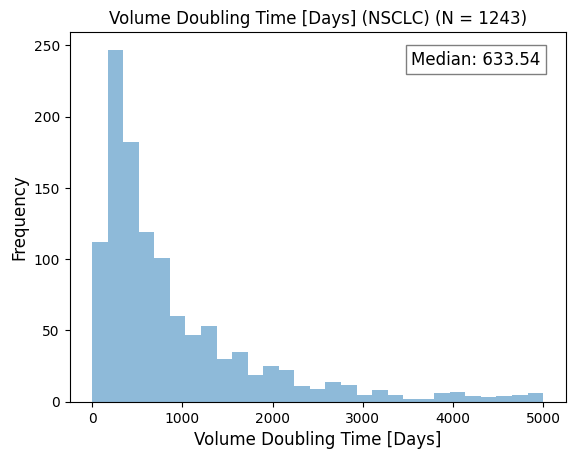

[65.97696554314325, 120.00475669200745, 1516.800698199891, 881.7903373010498, 501.5361302657608, 730.7973529625359, 2445.3249576952703, 356.2695745213929, 3744.6837819598713, 191.94364737280628, 206.71069444208075, 711.146548498167, 1551.6153432158412, 2343.6440672817535, 360.0454933885631, 3891.259042222453, 249.11448116460838, 168.9990431621447, 851.2364645945769, 601.0972581417268, 1166.876833173865, 140.43286218436495, 287.39610732874866, 1585.2241269317008, 394.77486647288555, 2709.051055388695, 540.8303314507044, 225.2080049081606, 351.84409318802085, 573.7844085123103, 2578.699621813838, 416.01845733482617, 308.9617895015464, 1094.152870569274, 458.778396744984, 1165.8000362959617, 766.9345343794702, 814.9513317396853, 374.7066562939826, 520.9821336736067, 2695.9127419637, 319.6814982699333, 1868.4283411360057, 3486.722825363131, 425.69396293047384, 563.8400567351756, 2164.9973993415433, 668.6451006998218, 103.24868262040454, 717.6487225901777, 1502.3345953372639, 176.0119203266

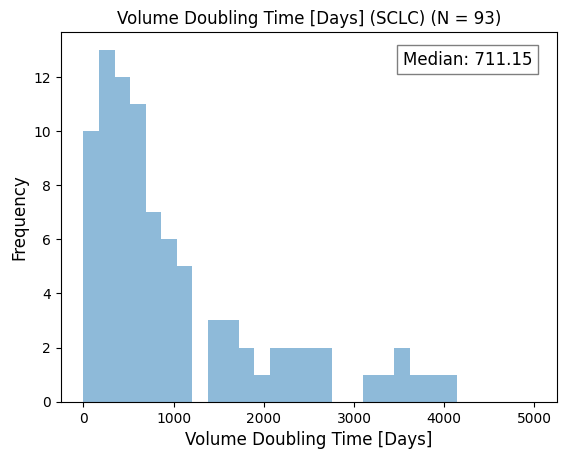

[]


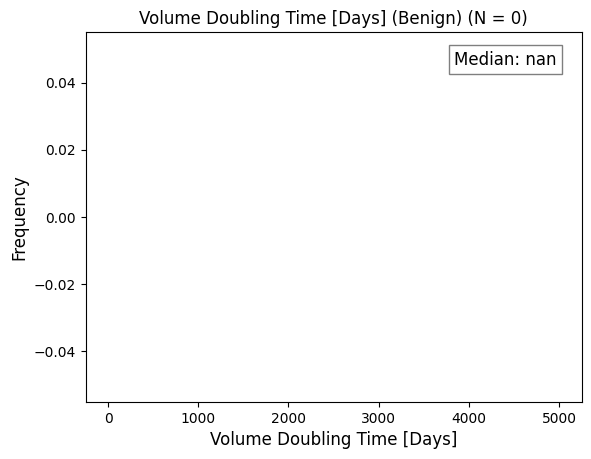

In [331]:
plot_distribution(growth_df["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days]", "Volume Doubling Time [Days]", "Frequency", with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (NSCLC)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (SCLC)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))
plot_distribution(growth_df[growth_df["cancer_type"] == "benign"]["doubling_time"].dropna().tolist(), "Volume Doubling Time [Days] (Benign)", "Volume Doubling Time [Days]", "Frequency",  with_mean=False, xlim=(0, 5000))

In [332]:
data_biggest_only = {}

In [333]:
for pid in data:
    data_biggest_only[pid] = data[pid].copy() # biggest only from latest one

    if data[pid]["matched_nodules"]:
        data_biggest_only[pid]["matched_nodules"] = {}

        if data[pid]["num_scans"] == 2:
            assert "T1" in data[pid]["total_num_voxels"] or "T2" in data[pid]["total_num_voxels"]

            if "T2" in data[pid]["total_num_voxels"]:
                latest_tp = "T2"
            else:
                latest_tp = "T1"

        elif data[pid]["num_scans"] == 3:
            latest_tp = "T2"
        
        latest_nodule_idx_to_latest_volume = {}
        for nodule_idx in data[pid]["matched_nodules"]:
            latest_nodule_idx_to_latest_volume[nodule_idx] = data[pid]["matched_nodules"][nodule_idx].get(latest_tp, {}).get("mask_volume", 0)
            
        latest_nodule_idx_to_keep = max([(k, v) for (k, v) in latest_nodule_idx_to_latest_volume.items()], key=lambda x:x[1])[0]

        data_biggest_only[pid]["matched_nodules"][latest_nodule_idx_to_keep] = data[pid]["matched_nodules"][latest_nodule_idx_to_keep]

In [334]:
growth_df_biggest_only, _, _, _ = compute_growth_statistics(data_biggest_only, metadata)

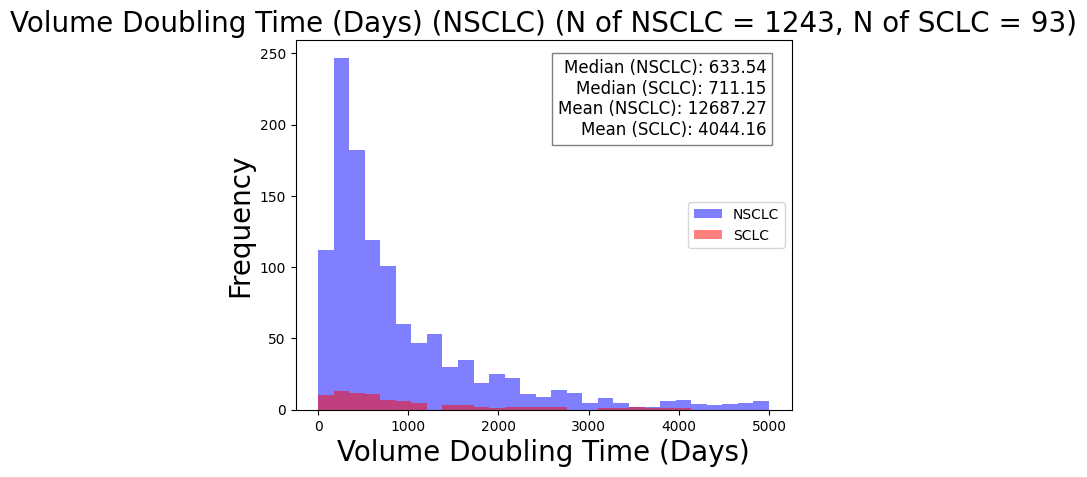

In [335]:
if is_cancer:
    plot_distribution_overlay(growth_df[growth_df["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), growth_df[growth_df["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time (Days) (NSCLC)", "Volume Doubling Time (Days)", "Frequency", "NSCLC", "SCLC", xlim=(0, 5000))

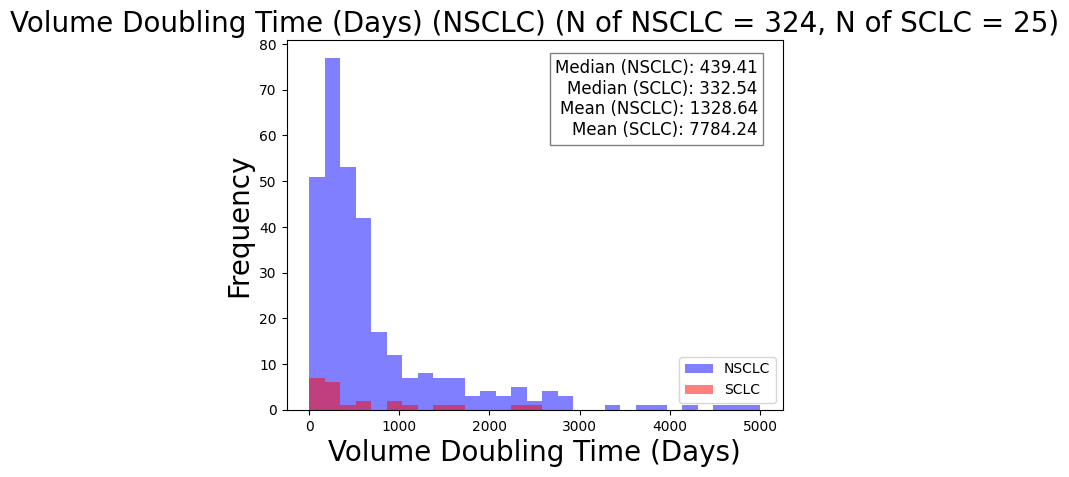

In [336]:
if is_cancer:
    plot_distribution_overlay(growth_df_biggest_only[growth_df_biggest_only["cancer_type"] == "NSCLC"]["doubling_time"].dropna().tolist(), growth_df_biggest_only[growth_df_biggest_only["cancer_type"] == "SCLC"]["doubling_time"].dropna().tolist(), "Volume Doubling Time (Days) (NSCLC)", "Volume Doubling Time (Days)", "Frequency", "NSCLC", "SCLC", (0, 5000))

In [337]:
print(f"Unmatched Earlier (SCLC): {unmatched_earlier['SCLC']}")
print(f"Unmatched Earlier (NSCLC): {unmatched_earlier['NSCLC']}")
print(f"Unmatched Earlier (Benign): {unmatched_earlier['benign']}")
print("\n")
print(f"Unmatched Later (SCLC): {unmatched_later['SCLC']}")
print(f"Unmatched Later (NSCLC): {unmatched_later['NSCLC']}")
print(f"Unmatched Later (Benign): {unmatched_later['benign']}")

Unmatched Earlier (SCLC): 434
Unmatched Earlier (NSCLC): 3739
Unmatched Earlier (Benign): 0


Unmatched Later (SCLC): 419
Unmatched Later (NSCLC): 3852
Unmatched Later (Benign): 0


## Novel Nodules

How often is there a novel nodule (i.e., an unmatched nodule in T1 and there is a scan for T0, or an unmatched nodule in T2 and there is a scan in T1)?

In [338]:
min_vol_threshold = (4/3) * math.pi * (3/2)**2 # assume

In [339]:
min_vol_threshold = 500

# Counters for T0→T1
appearing_01 = 0
den_01       = 0

# Counters for T1→T2
appearing_12 = 0
den_12       = 0

for pid, pid_entry in data.items():
    scans = pid_entry["total_num_nodules"].keys()
    has_t0 = "T0" in scans
    has_t1 = "T1" in scans
    has_t2 = "T2" in scans

    # Precompute unmatched volumes
    unmatched = pid_entry["unmatched_nodules"].values()
    unmatched_t1 = any(
        e["timepoint"] == "T1" and e["mask_volume"] >= min_vol_threshold
        for e in unmatched
    )
    unmatched_t2 = any(
        e["timepoint"] == "T2" and e["mask_volume"] >= min_vol_threshold
        for e in unmatched
    )

    # Precompute “newly matched” at T1 (i.e. present only at T1 in the match dict)
    matched = pid_entry["matched_nodules"].values()
    new_at_t1 = any(
        ("T1" in m) and ("T0" not in m) and (m["T1"]["mask_volume"] >= min_vol_threshold)
        for m in matched
    )

    # --- T0 → T1 appearance ---
    if has_t0 and has_t1:
        den_01 += 1
        # either truly new at T1, or an unmatched T1 above threshold
        if new_at_t1 or unmatched_t1:
            appearing_01 += 1

    # --- T1 → T2 appearance ---
    if has_t1 and has_t2:
        den_12 += 1
        if unmatched_t2:
            appearing_12 += 1

# Compute rates
rate_01 = appearing_01 / den_01 if den_01 else float('nan')
rate_12 = appearing_12 / den_12 if den_12 else float('nan')

print(f"T0→T1 appearance: {appearing_01}/{den_01} = {rate_01:.4f}")
print(f"T1→T2 appearance: {appearing_12}/{den_12} = {rate_12:.4f}")

T0→T1 appearance: 253/414 = 0.6111
T1→T2 appearance: 159/276 = 0.5761


In [340]:
disappearing_01 = 0  # T0→T1 lost
den_01         = 0  # T0→T1 eligible

disappearing_12 = 0  # T1→T2 lost
den_12         = 0  # T1→T2 eligible

for pid, pid_entry in data.items():
    scans = pid_entry["total_num_nodules"].keys()
    has_t0 = "T0" in scans
    has_t1 = "T1" in scans
    has_t2 = "T2" in scans

    # 1) T0 → T1
    if has_t0 and has_t1:
        den_01 += 1
        # did any T0 nodule go unmatched forward?
        lost_from_t0 = any(
            entry["timepoint"] == "T0"
            for entry in pid_entry["unmatched_nodules"].values()
        )
        if lost_from_t0:
            disappearing_01 += 1

    # 2) T1 → T2
    if has_t1 and has_t2:
        den_12 += 1
        lost_from_t1 = any(
            entry["timepoint"] == "T1"
            for entry in pid_entry["unmatched_nodules"].values()
        )
        if lost_from_t1:
            disappearing_12 += 1

# Compute rates
rate_01 = disappearing_01 / den_01 if den_01 else float('nan')
rate_12 = disappearing_12 / den_12 if den_12 else float('nan')

print(f"T0→T1 disappearance: {disappearing_01}/{den_01} = {rate_01:.4f}")
print(f"T1→T2 disappearance: {disappearing_12}/{den_12} = {rate_12:.4f}")

T0→T1 disappearance: 402/414 = 0.9710
T1→T2 disappearance: 263/276 = 0.9529


<!-- How many patients of 685 have an unmatched nodule?

Exclude patients -->

In [341]:
# disappearing = 0
# denom1 = 0

# for pid, pid_entry in data.items():
#     unmatched_t0 = any([entry["timepoint"] == "T0" for entry in data[pid]["unmatched_nodules"].values()])
#     unmatched_t1 = any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()])
#     unmatched_t2 = any([entry["timepoint"] == "T2" for entry in data[pid]["unmatched_nodules"].values()])

#     scans = list(pid_entry["total_num_nodules"].keys())

#     has_t0 = "T0" in scans
#     has_t1 = "T1" in scans
#     has_t2 = "T2" in scans

#     has_match_at_T1_without_T0 = any(["T1" in entry and "T0" not in entry for entry in data[pid]["matched_nodules"].values()])
    
#     ###

#     if (unmatched_t0 and (has_t1 or has_t2)) or (unmatched_t1 and has_t2):
#         disappearing += 1

#     if len(scans) > 1: # all of the people we are allowed to count
#         denom1 += 1

# print(disappearing / denom1)

In [342]:
min_vol_threshold1 = 500

appearing = 0
denom1 = 0

for pid, pid_entry in data.items():
    unmatched_t0 = any([entry["timepoint"] == "T0" and entry["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["unmatched_nodules"].values()])
    unmatched_t1 = any([entry["timepoint"] == "T1" and entry["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["unmatched_nodules"].values()])
    unmatched_t2 = any([entry["timepoint"] == "T2" and entry["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["unmatched_nodules"].values()])

    scans = list(pid_entry["total_num_nodules"].keys())

    has_t0 = "T0" in scans
    has_t1 = "T1" in scans
    has_t2 = "T2" in scans

    has_match_at_T1_without_T0 = any(["T1" in entry and "T0" not in entry and entry["T1"]["mask_volume"] >= min_vol_threshold1 for entry in data[pid]["matched_nodules"].values()])
    
    ###

    if (has_t0 and (has_match_at_T1_without_T0 or unmatched_t1)) or ((has_t0 or has_t1) and unmatched_t2):
        appearing += 1

    if len(scans) > 1: # all of the people we are allowed to count
        denom1 += 1

print(appearing / denom1)

0.7333333333333333


In [343]:
pid_entry

{'matched_nodules': {'0': {'T0': {'mask_volume': 273.13232421875,
    'instance_label': 1,
    'centroid_distance_to_T1_nodule': 11.393509029036649,
    'min_distance_to_T1_nodule': 3.7416573867739413,
    'iou_with_T1_nodule_after_reg': 0.0,
    'has_bbox_overlap': False,
    'mask_slice_range': [163, 164, 165, 166, 167, 168, 169, 170],
    'bbox_slice_range': []},
   'T1': {'mask_volume': 29.754638671875,
    'instance_label': 10,
    'centroid_distance_to_T0_nodule': 11.393509029036649,
    'min_distance_to_T0_nodule': 3.7416573867739413,
    'iou_with_registered_T0_nodule': 0.0,
    'has_bbox_overlap': False,
    'mask_slice_range': [151, 152],
    'bbox_slice_range': []}},
  '1': {'T0': {'mask_volume': 90.02685546875,
    'instance_label': 2,
    'centroid_distance_to_T1_nodule': 14.309745192903238,
    'min_distance_to_T1_nodule': 7.810249675906654,
    'iou_with_T1_nodule_after_reg': 0.0,
    'has_bbox_overlap': False,
    'mask_slice_range': [86, 87, 88, 89, 90, 91, 92, 93],
  

In [344]:
    # if len(data[pid]["unmatched_nodules"]) > 0:
    #     count1 += 1
    
    # if 
    #     disappeared0 += 1
    
    # if any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()]):
    #     disappeared1 += 1

In [345]:
pid_entry

{'matched_nodules': {'0': {'T0': {'mask_volume': 273.13232421875,
    'instance_label': 1,
    'centroid_distance_to_T1_nodule': 11.393509029036649,
    'min_distance_to_T1_nodule': 3.7416573867739413,
    'iou_with_T1_nodule_after_reg': 0.0,
    'has_bbox_overlap': False,
    'mask_slice_range': [163, 164, 165, 166, 167, 168, 169, 170],
    'bbox_slice_range': []},
   'T1': {'mask_volume': 29.754638671875,
    'instance_label': 10,
    'centroid_distance_to_T0_nodule': 11.393509029036649,
    'min_distance_to_T0_nodule': 3.7416573867739413,
    'iou_with_registered_T0_nodule': 0.0,
    'has_bbox_overlap': False,
    'mask_slice_range': [151, 152],
    'bbox_slice_range': []}},
  '1': {'T0': {'mask_volume': 90.02685546875,
    'instance_label': 2,
    'centroid_distance_to_T1_nodule': 14.309745192903238,
    'min_distance_to_T1_nodule': 7.810249675906654,
    'iou_with_T1_nodule_after_reg': 0.0,
    'has_bbox_overlap': False,
    'mask_slice_range': [86, 87, 88, 89, 90, 91, 92, 93],
  

In [346]:
novel_nodule_data = {}

for pid, pid_entry in data.items():
    # has_scan_T0 = "T0" in pid_entry["total_num_nodules"]
    # has_scan_T1 = "T1" in pid_entry["total_num_nodules"]

    has_unmatched_nodules_nodule_in_T0 = any([entry["timepoint"] == "T0" for entry in data[pid]["unmatched_nodules"].values()])
    has_unmatched_nodules_nodule_in_T1 = any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()])

    novel_nodule_data[pid] = {"unmatched_nodules": {}}

    for unmatched_nodule_id, unmatched_nodule_entry in data[pid]["unmatched_nodules"].items():
        if unmatched_nodule_entry["mask_volume"] >= min_vol_threshold:
            if (unmatched_nodule_entry["timepoint"] == "T1" and has_unmatched_nodules_nodule_in_T0) or (unmatched_nodule_entry["timepoint"] == "T2" and (has_unmatched_nodules_nodule_in_T1 or has_unmatched_nodules_nodule_in_T0)):
                novel_nodule_data[pid]["unmatched_nodules"][unmatched_nodule_id] = unmatched_nodule_entry


Over the number of nodules instead of patients

(Go nodule-by-nodule of the unmatched nodules -> does it appear? disappear?)

In [347]:
num_pids_with_at_least_one_novel_nodule = 0

for pid, pid_entry in novel_nodule_data.items():
    if pid_entry["unmatched_nodules"]:
        num_pids_with_at_least_one_novel_nodule += 1

print(f"{num_pids_with_at_least_one_novel_nodule * 100 / len(novel_nodule_data)}% of patients have at least one novel nodule")

43.43434343434343% of patients have at least one novel nodule


## Disappearing Nodules

In [348]:
disappearing_nodule_data = {}


for pid, pid_entry in data.items():
    has_unmatched_nodules_nodule_in_T1 = any([entry["timepoint"] == "T1" for entry in data[pid]["unmatched_nodules"].values()])
    has_unmatched_nodules_nodule_in_T2 = any([entry["timepoint"] == "T2" for entry in data[pid]["unmatched_nodules"].values()])

    disappearing_nodule_data[pid] = {"unmatched_nodules": {}}

    # maybe add a minimum volume threshold?

    for unmatched_nodule_id, unmatched_nodule_entry in data[pid]["unmatched_nodules"].items():
        if unmatched_nodule_entry["mask_volume"] >= min_vol_threshold:
            if (unmatched_nodule_entry["timepoint"] == "T0" and not has_unmatched_nodules_nodule_in_T1) or (unmatched_nodule_entry["timepoint"] == "T1" and not has_unmatched_nodules_nodule_in_T2):
                disappearing_nodule_data[pid]["unmatched_nodules"][unmatched_nodule_id] = unmatched_nodule_entry


In [349]:
num_pids_with_at_least_one_disappearing_nodule = 0

for pid, pid_entry in disappearing_nodule_data.items():
    if pid_entry["unmatched_nodules"]:
        num_pids_with_at_least_one_disappearing_nodule += 1

print(f"{num_pids_with_at_least_one_disappearing_nodule * 100 / len(disappearing_nodule_data)}% of patients have at least one disappearing nodule")

49.20634920634921% of patients have at least one disappearing nodule


In [350]:
num_pids_with_at_least_one_disappearing_nodule

341

## Early Detection

In [351]:
metadata

,PID,IsSmallCell,CancerTP,NumExams,Days2Cancer_0,DaysSinceRand_0,Annotated_0,Days2FUP_0,Series_0,abnormalities_0,...,change_2,exists_2,slice_number_2,age_2,years_since_quit_smoking_2,age_start_smoking,age_quit_smoking,years_smoking,is_smoker,family_hx
0,104363,False,0.0,1,20.0,57.0,1.2.840.113654.2.55.31289205206602048621229111...,2623.0,['1.2.840.113654.2.55.312892052066020486212291...,[51],...,[],[],[],NaN,NaN,15.0,-1.0,49,1,False
1,126514,False,4.0,3,1744.0,23.0,NaN,2099.0,['1.2.840.113654.2.55.151058074685137500542581...,[51],...,"[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]",69.0,15.0,13.0,54.0,41,0,False
2,215101,False,2.0,2,NaN,NaN,NaN,NaN,[],[],...,"[1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[2.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[124.0, -1.0, -1.0, -1.0, -1.0, -1.0]",71.0,0.0,15.0,-1.0,53,1,False
3,118560,False,2.0,3,924.0,0.0,NaN,2657.0,['1.2.840.113654.2.55.271320444115083086313603...,[65],...,[-1.0],[1.0],[51.0],71.0,8.0,30.0,63.0,33,0,False
4,107791,False,0.0,1,33.0,22.0,1.2.840.113654.2.55.12444939297447887113142959...,2440.0,['1.2.840.113654.2.55.124449392974478871131429...,"[51, 56, 60]",...,[],[],[],NaN,NaN,25.0,66.0,41,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,122025,False,0.0,1,63.0,39.0,1.2.840.113654.2.55.24358410500449861747917111...,531.0,['1.2.840.113654.2.55.243584105004498617479171...,"[51, 51, 65]",...,[],[],[],NaN,NaN,15.0,-1.0,56,1,False
821,216160,False,1.0,2,459.0,0.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.116685732054...,2638.0,['1.3.6.1.4.1.14519.5.2.1.7009.9004.8270077794...,[51],...,[],[],[],NaN,NaN,12.0,-1.0,33,1,True
822,111261,False,4.0,1,1510.0,23.0,NaN,2533.0,['1.2.840.113654.2.55.164498555701873314300047...,"[51, 60, 64, 61, 55]",...,[],[],[],NaN,NaN,17.0,60.0,43,0,False
823,203581,False,2.0,3,836.0,0.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.533941689505...,2462.0,['1.3.6.1.4.1.14519.5.2.1.7009.9004.5339416895...,[],...,"[-1.0, 1.0, -1.0, -1.0]","[1.0, 2.0, -1.0, -1.0]","[63.0, 61.0, -1.0, -1.0]",63.0,0.0,18.0,-1.0,43,1,False


In [352]:
metadata[metadata["PID"] == 116837]["Days2Cancer_1"]

537    493.0
Name: Days2Cancer_1, dtype: float64

In [353]:
def pid_is_annotated(df, pid):
    row = metadata[metadata["PID"] == pid]
    return bool((row["Annotated_0"].notna().values[0]) or (row["Annotated_1"].notna().values[0]) or (row["Annotated_2"].notna().values[0]))

In [354]:
count = 0

data_with_annotations = {}

for pid in data:
    if pid_is_annotated(metadata, int(pid)):
        data_with_annotations[pid] = data[pid]

In [355]:
len(data_with_annotations)

477

In [356]:
compute_basic_statistics(data_with_annotations, should_prune_t0, include_ann_nodules_only)

{'num_patients': 477,
 'num_patients_1_scan': 232,
 'num_patients_2_scan': 132,
 'num_patients_3_scan': 113,
 'num_scans': 835,
 'total_predicted_nodules': 8917,
 'unmatched_nodules': 6332,
 'matched_nodules_2': 889,
 'matched_nodules_3': 269,
 'num_patients_with_annotations': 475,
 'num_scans_with_annotations': 774}

## Early Detection with Annotations

In [357]:
numerator = 0
denominator = 0

days_to_cancer_earliest, days_to_cancer_latest = [], []

for pid in data:
    for nodule_idx, nodule_entry in data[pid]["matched_nodules"].items():
        if any([tp_entry["has_bbox_overlap"] for tp, tp_entry in nodule_entry.items() if tp != "T0"]):
            denominator += 1

            row = metadata[metadata["PID"] == int(pid)]

            if "T2" in nodule_entry and nodule_entry["T2"]["has_bbox_overlap"]:
                if "T0" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_0"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_0"].dropna().values[0]))

                elif "T1" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_1"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_1"].dropna().values[0]))
                

                if len(row["Days2Cancer_2"].dropna()) == 1:
                    days_to_cancer_latest.append(int(row["Days2Cancer_2"].dropna().values[0]))
            

            elif "T1" in nodule_entry and nodule_entry["T1"]["has_bbox_overlap"]:
                if "T0" in nodule_entry:
                    numerator += 1

                    if len(row["Days2Cancer_0"].dropna()) == 1:
                        days_to_cancer_earliest.append(int(row["Days2Cancer_0"].dropna().values[0]))
                
                if len(row["Days2Cancer_1"].dropna()) == 1:
                    days_to_cancer_latest.append(int(row["Days2Cancer_1"].dropna().values[0]))
        

In [358]:
# metadata[["Days2Cancer_0", "Days2Cancer_1", "Days2Cancer_2"]]
metadata["Days2Cancer_1"].isna().value_counts()

Days2Cancer_1
False    533
True     292
Name: count, dtype: int64

In [359]:
print(numerator / denominator) 

0.9788732394366197


In [360]:
numerator

139

In [361]:
denominator

142

In [362]:
days_to_cancer_earliest

[415,
 814,
 796,
 799,
 834,
 441,
 700,
 430,
 414,
 1016,
 491,
 978,
 561,
 1029,
 545,
 392,
 421,
 403,
 640,
 839,
 549,
 482,
 645,
 517,
 436,
 436,
 849,
 1018,
 816,
 766,
 423,
 523,
 390,
 390,
 390,
 876,
 495,
 462,
 384,
 475,
 679,
 484,
 494,
 419,
 445,
 707,
 488,
 585,
 585,
 676,
 418,
 895,
 648,
 1049,
 300,
 383,
 802,
 387,
 419,
 741,
 741,
 861,
 408,
 408,
 408,
 798,
 1012,
 417,
 1059,
 440,
 1185,
 560,
 440,
 440,
 389,
 836,
 791,
 832,
 638,
 447,
 400,
 562,
 460,
 476,
 436,
 456,
 357,
 439,
 1018,
 799,
 810,
 1061,
 798,
 734,
 396,
 393,
 497,
 781,
 756,
 487,
 508,
 655,
 402,
 409,
 774,
 482,
 438,
 410,
 432,
 403,
 343,
 504,
 596,
 779,
 1023,
 446,
 421,
 889,
 409,
 975,
 459,
 622,
 777,
 799,
 821,
 398,
 881,
 541,
 403,
 503,
 503,
 753,
 753,
 411,
 763,
 784,
 832,
 863,
 510]

[415, 814, 796, 799, 834, 441, 700, 430, 414, 1016, 491, 978, 561, 1029, 545, 392, 421, 403, 640, 839, 549, 482, 645, 517, 436, 436, 849, 1018, 816, 766, 423, 523, 390, 390, 390, 876, 495, 462, 384, 475, 679, 484, 494, 419, 445, 707, 488, 585, 585, 676, 418, 895, 648, 1049, 300, 383, 802, 387, 419, 741, 741, 861, 408, 408, 408, 798, 1012, 417, 1059, 440, 1185, 560, 440, 440, 389, 836, 791, 832, 638, 447, 400, 562, 460, 476, 436, 456, 357, 439, 1018, 799, 810, 1061, 798, 734, 396, 393, 497, 781, 756, 487, 508, 655, 402, 409, 774, 482, 438, 410, 432, 403, 343, 504, 596, 779, 1023, 446, 421, 889, 409, 975, 459, 622, 777, 799, 821, 398, 881, 541, 403, 503, 503, 753, 753, 411, 763, 784, 832, 863, 510]


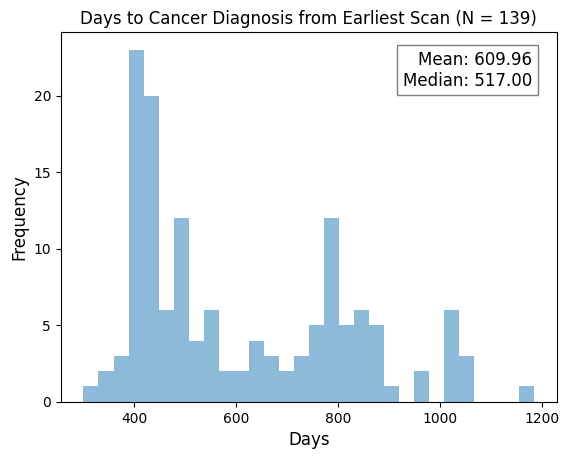

[72, 156, 60, 68, 454, 56, 349, 87, 55, 41, 68, 566, 219, 35, 183, 42, 21, 28, 277, 112, 101, 47, 251, 174, 46, 46, 506, 247, 92, 264, 84, 179, 54, 54, 54, 64, 15, 633, 60, 43, 83, 19, 39, 52, 64, 52, 56, 120, 166, 166, 326, 55, 164, 264, 349, 686, 74, 46, 387, 100, 42, 390, 390, 56, 15, 15, 15, 49, 310, 55, 325, 56, 675, 55, 20, 69, 21, 77, 124, 76, 173, 112, 36, 121, 67, 112, 66, 60, 14, 70, 145, 94, 96, 361, 49, 48, 67, 72, 88, 42, 97, 59, 123, 356, 45, 13, 116, 139, 91, 88, 54, 64, 483, 6, 123, 277, 49, 323, 75, 78, 175, 47, 114, 67, 14, 38, 58, 73, 5, 32, 221, 35, 75, 75, 15, 15, 15, 42, 99, 110, 86, 120]


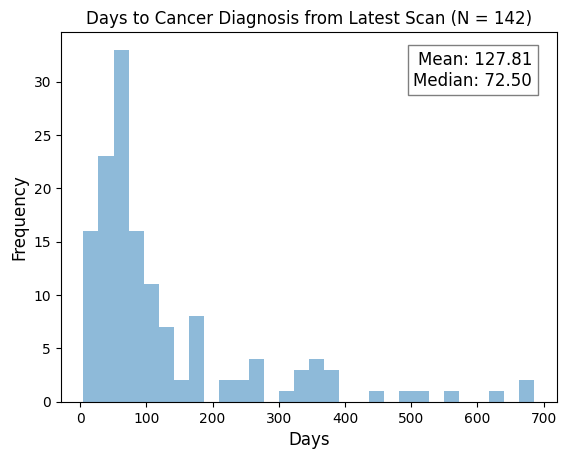

In [363]:
plot_distribution(days_to_cancer_earliest, "Days to Cancer Diagnosis from Earliest Scan", "Days", "Frequency")
plot_distribution(days_to_cancer_latest, "Days to Cancer Diagnosis from Latest Scan", "Days", "Frequency")

## Overlaying Distributions

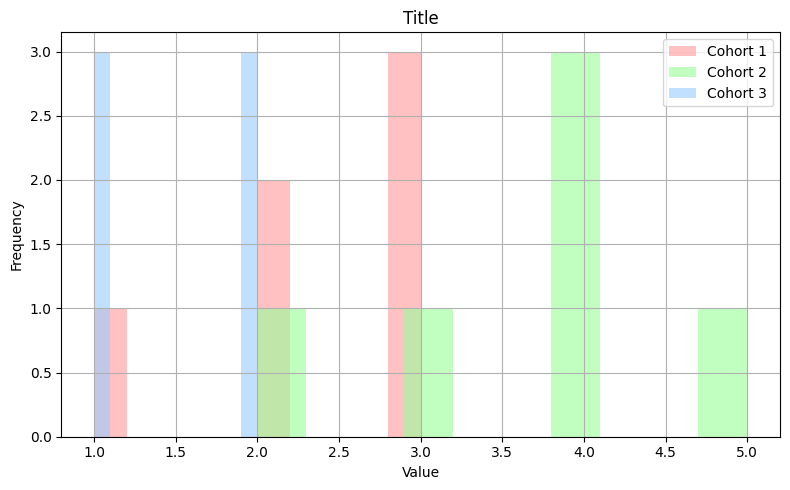

In [364]:
data1 = [1, 2, 2, 3, 3, 3]
data2 = [2, 3, 4, 4, 4, 5]
data3 = [1, 1, 1, 2, 2, 2]

colors = ['#FF9999', '#99FF99', '#99CCFF']
alpha = 0.6

plt.figure(figsize=(8, 5))
plt.hist(data1, bins=10, alpha=alpha, color=colors[0], label='Cohort 1')
plt.hist(data2, bins=10, alpha=alpha, color=colors[1], label='Cohort 2')
plt.hist(data3, bins=10, alpha=alpha, color=colors[2], label='Cohort 3')

plt.title('Title')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Growth Over Time (Stratified by Nodule Type)

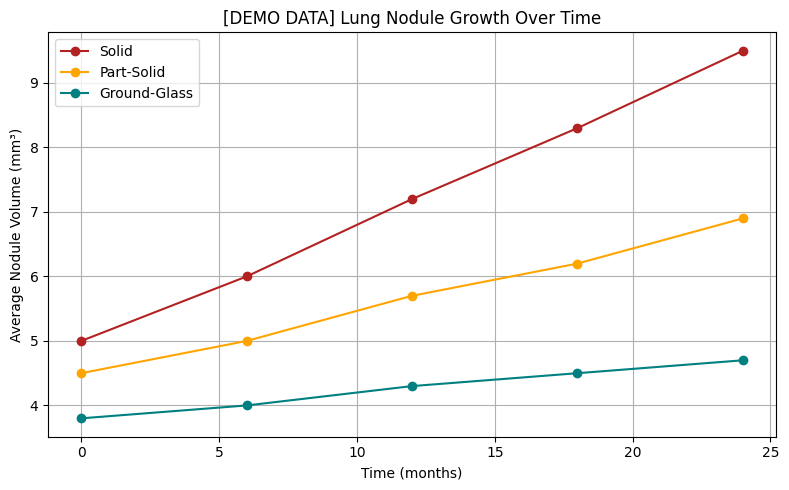

In [365]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# simulated data
time_months = np.array([0, 6, 12, 18, 24])

solid_growth = [5.0, 6.0, 7.2, 8.3, 9.5]
part_solid_growth = [4.5, 5.0, 5.7, 6.2, 6.9]
ground_glass_growth = [3.8, 4.0, 4.3, 4.5, 4.7]

df = pd.DataFrame({
    'Time (months)': time_months,
    'Solid': solid_growth,
    'Part-Solid': part_solid_growth,
    'Ground-Glass': ground_glass_growth
})

plt.figure(figsize=(8, 5))
plt.plot(df['Time (months)'], df['Solid'], label='Solid', color='firebrick', marker='o')
plt.plot(df['Time (months)'], df['Part-Solid'], label='Part-Solid', color='orange', marker='o')
plt.plot(df['Time (months)'], df['Ground-Glass'], label='Ground-Glass', color='teal', marker='o')

plt.title('[DEMO DATA] Lung Nodule Growth Over Time')
plt.xlabel('Time (months)')
plt.ylabel('Average Nodule Volume (mm³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
